<a href="https://colab.research.google.com/github/jamesterryxu/dsa-2024/blob/main/GNNs_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.3.1+cu121 with cuda 12.1


In [ ]:
#!pip install torch_geometric

# Optional dependencies:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [9]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [105]:
import networkx as nx
from torch_geometric.utils import to_networkx
H = nx.DiGraph()

#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

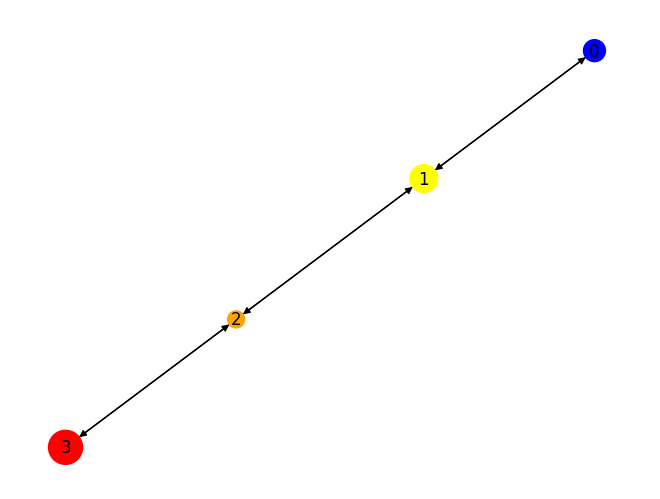

In [11]:
#adding edges
H.add_edges_from([
  (0, 1),
  (1, 0),

  (1, 2),
  (2, 1),

  (2, 3),
  (3, 2),


])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

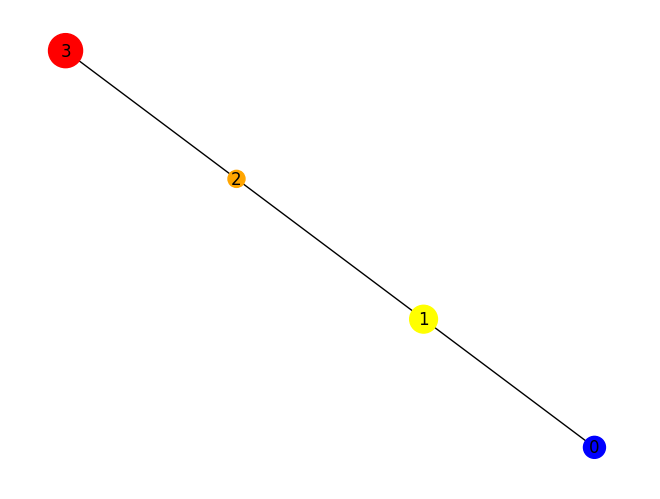

In [12]:
#converting to undirected graph
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [13]:
# Check version of cuda
import torch
print(torch.__version__)
print(torch.version.cuda)

2.3.1+cu121
12.1


MLP class function

In [128]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, hidden_n_layers, activation=nn.ReLU, normalization=True):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.hidden_n_layers = hidden_n_layers
        self.activation = activation
        self.normalization = normalization

        # Create the MLP layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_dim))
        for _ in range(hidden_n_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_size))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation()(x)
                if self.normalization:
                    x = nn.LayerNorm(x.shape[-1])(x)
        return x


## Encoder

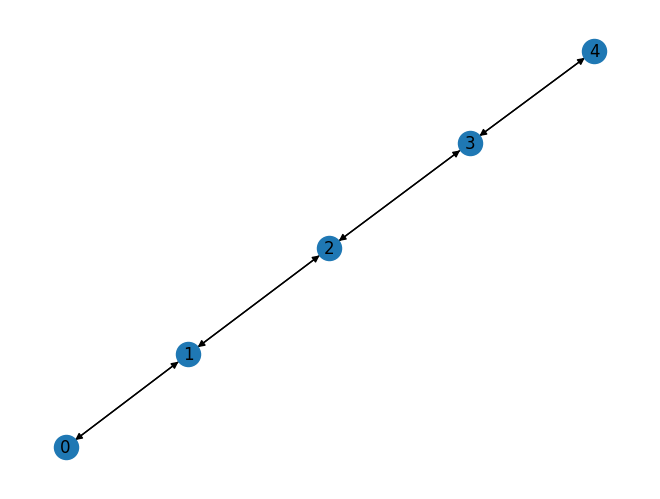

In [134]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates):
    # Convert coordinates to tensor
    node_features = torch.tensor(coordinates, dtype=torch.float)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(node_features, r=1.1, loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    edge_attr = torch.norm(node_features[edge_index[0]] - node_features[edge_index[1]], dim=1).unsqueeze(1)

    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

    return data

# Example usage
coordinates = [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0)]
graph_data = create_gnn_graph(coordinates)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)

## Message passing

In [135]:
class MsgPassing(MessagePassing):
  def __init__(self, in_channels, out_channels, edge_features):
        super().__init__(aggr='add')  # Use 'add' aggregation.

        # MLP for node features
        self.node_mlp = MLP(in_channels, out_channels, out_channels, 1)

        # MLP for edge features
        self.edge_mlp = MLP(edge_features, out_channels, out_channels, 1)

  def forward(self, x, edge_index, edge_attr):
        # Add self-loops to the edge index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Apply MLP to node features
        node_features = self.node_mlp(x)

        # Apply MLP to edge features
        edge_features = self.edge_mlp(edge_attr)

        # Update node features using message passing
        return self.propagate(edge_index, x=node_features, edge_attr=edge_features)

  def message(self, x_j, edge_attr):
        return edge_attr * x_j



In [139]:
coordinates = [(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0)]
graph_data = create_gnn_graph(coordinates)

out = MsgPassing(in_channels=3, out_channels=16, edge_features=1)(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
print(out.shape)


RuntimeError: The size of tensor a (8) must match the size of tensor b (13) at non-singleton dimension 0

## Decoder

In [137]:
class GraphDecoder(nn.Module):
    def __init__(self, hidden_dim, hidden_n_layers):
        super(GraphDecoder, self).__init__()
        self.mlp = MLP(input_size=hidden_dim, output_size=2, hidden_dim=hidden_dim, hidden_n_layers=hidden_n_layers)

    def forward(self, x):
        return self.mlp(x)


In [138]:
# Assuming 'out' is the output of your message passing layer
decoder = GraphDecoder(hidden_dim=16, hidden_n_layers=2)  # Example decoder
decoded_output = decoder(out)

print(decoded_output.shape)  # Should print: torch.Size([5, 2])

NameError: name 'out' is not defined

## Complete function